# Assignment 2: SoC Module Recommender System

In [1]:
#It's for google colab usage on google drive.
#Ignore or change folder path that corresponds to your environment.
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

COLAB_PATH = '/content/drive/My Drive/IT5006/Assignment2'

import sys, os
sys.path.append(COLAB_PATH)
print(sys.path)
## change directory to the path above
os.chdir(COLAB_PATH)

Mounted at /content/drive
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/IT5006/Assignment2']


## Instructions to submit the assignment

- Name your jupyter notebook as `Assignment2_[StudentID].ipynb`. For instance: `Assignment2_A0123873A.ipynb`
- Your solution notebook must contain the python code that we can run to verify the answers.
- Upload your jupyter notebook on LumiNUS in the *Assignment 1 Submissions* folder. The folder will close at 6pm on 03/04/2021. Late submissions will receive a penalty on the grade as follows:
  - late within 1 hour: 10% reduction in grade
  - late within 6 hours: 30% reduction in grade
  - late within 12 hours: 50% reduction in grade
  - late within 1 days: 70% reduction in grade
  - after 1 days: zero mark

In this assignment we design a reccomendation engine. The recommendation engine suggests the students a module that closely matches the modules already taken by the student. The dataset comprices of two files:
- List of modules in the School of Computing 
- List of graduated students and the modules they had taken during their studies

# Loading the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

'''
    YOU MUST USE THE RANDOM SEED WHEREVER NEEDED
'''
#By np.random.default_rng, in my case it raised error when in used at 
#PCA. So, I used RandomState(seed=42) instead.
#rng = np.random.default_rng(seed=42)
rng = np.random.RandomState(seed=42)

courses = pd.read_csv("courses.csv", sep='\t')
students = pd.read_csv("students.csv", sep='\t')

Data checking is as follows.

In [3]:
courses.tail()

,code,name,workload,info
154,CS5244,Digital Libraries,2-0-0-6-2,This module is targeted to graduate students o...
155,CS6243,Computational Photography,3-0-0-4-3,This course covers the exciting new area of “C...
156,CS6244,Robot Motion Planning & Control,2-0-0-5-3,An array of new robots with amazing capabiliti...
157,CS6270,Virtual Machines,2-0-0-2-6,Virtual machines (VMs) are increasingly being ...
158,CS6280,Datacentre Software Dynamics,2-0-0-4-4,Datacenter computing favors response time over...


In [4]:
students.head()

,Degree,GPA,modules
0,1,3.491504,"CS2105,CS4222,CS6270,CS6205,CS4226,CS3282,CS62..."
1,1,3.325944,"CS4271,CS4239,CS3235,CS2107,CS5439,CS5331,CS62..."
2,1,4.816216,"CS5330,CS4234,CS6220,CS3230,CS4248,CS5344,CS42..."
3,1,3.104497,"CS4239,CS3234,CS3282,CS3882,CS3217,CS3281,CS52..."
4,1,4.168558,"CS5346,CS6213,CS4225,CS5344,CS4221,CS6280,CS62..."


# Question 1: Creating the preprocessing pipeline

We want to create a sklearn pipeline to efficiently preprocess the data and prepare it for training a model. There are three different features in the `courses` data: `code`, `info` and `workload`. We want to represent every feature in a numeric form and merge them to form a feature vector for every course. We do so in the following way:
- `code` represents one of the six levels of the module 1, 2, 3, 4, 5, or 6. For instance: IT5006 is a level 5 module. We want to extract the level of the module from its code.
- `info` provides a short discription of the module. We want to convert it into a vector using CountVectorizer. *Don't forget to remove the stopwords* while doing so.
-  `workload` states the intended distribution of workload over lectures, tutorials, labs and self study. We want to find the workload as the sum of individual workloads. For instnce: 3-1-1-3-2 workload transforms to 10 hours.

Provide implementation for three classes that help us build the pipeline. `transformed_courses` should be a numpy array of shape `[n_courses X n_features]`.

                                                                                                   (6 marks)

In [5]:
#import some necessary libraries here
import re
import nltk
import string
from nltk.corpus import stopwords
import itertools

In [6]:
class WorkloadTransformer:        
    def fit(self, X, y = None, **fit_params):
        '''
            Write your code here
        '''
        return self
    
    def transform(self, X, y = None, **fit_params):
        '''
            Write your code here
        '''
        workload_num = X['workload'].apply(lambda x: re.findall(r'\d+', x))
        workload_val = workload_num.apply(lambda x: list(map(float, x)))
        workload_sum = workload_val.apply(lambda x: sum(x))
        workload_sum = workload_sum.to_numpy()
        workload_sum = workload_sum.reshape(len(workload_sum),1)

        return workload_sum

In [8]:
class InfoTransformer:        

    def __init__(self):
        
        #For stopword operation.
        nltk.download('stopwords')
        self.stop = stopwords.words('english')

    def fit(self, X, y = None, **fit_params):
        '''
            Write your answer here
        '''
        return self
    
    def transform(self, X, y = None, **fit_params):
        '''
            Write your code here
        '''
        #Using the list of stop words.
        stop = self.stop

        #function to execute removing stopwords.
        def removeStopwords(text): 
          text = text.lower()
          regex = re.compile('['+re.escape(string.punctuation) + '0-9\\r\\t\\n'+']')
          txt = regex.sub('',text)  #remove punctuation
          # remove stop words and words with length smaller than 3 letters
          words = [w for w in txt.split(' ') if w not in stop] 
          words = ' '.join(word for word in words)
          return words

        #Generating text data after executing removeStopwords.
        processed_info = X['info'].apply(lambda x: removeStopwords(x))
        count_vect = CountVectorizer()
        info_vect = count_vect.fit_transform(processed_info).todense()
          
        return info_vect

In [9]:
class CodeTransformer:        
    def fit(self, X, y = None, **fit_params):
        '''
            Write your code here
        '''
        return self
    
    def transform(self, X, y = None, **fit_params):
        '''
            Write your code here
        '''
        #Finding numbers in code i.e. CS2105 -> extracting only 2105.
        code_num = X['code'].apply(lambda x: re.findall(r'\d+', x))
        #Changing '2105' into integer of 2105.
        code_num_val = code_num.apply(lambda x: int(x[0]))
        #By dividing by 1000 and taking division quantient
        #i.e. in case of 2105, 2105//1000 = 2 i.e. level 2.
        class_num = code_num_val // 1000
        class_num = class_num.to_numpy()
        class_num = class_num.reshape(len(class_num),1)

        return class_num

Execution of featureTransformer

In [10]:
featureTransformer = FeatureUnion([
    ('workload_processing', Pipeline([('wrkld', WorkloadTransformer())])),
    ('info_processing', Pipeline([('info', InfoTransformer())])),
    ('code_processing', Pipeline([('code', CodeTransformer())])),
])

featureTransformer.fit(courses)
transformed_courses = featureTransformer.transform(courses)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Checking data after featureTransformer.

In [11]:
transformed_courses.shape

(159, 2160)

In [ ]:
transformed_courses

matrix([[10.,  0.,  0., ...,  0.,  0.,  2.],
        [19.,  0.,  0., ...,  0.,  0.,  2.],
        [10.,  0.,  0., ...,  0.,  0.,  2.],
        ...,
        [10.,  0.,  0., ...,  0.,  0.,  6.],
        [10.,  0.,  0., ...,  0.,  0.,  6.],
        [10.,  0.,  0., ...,  0.,  0.,  6.]])

Now we prepare our testing data in the same way we preprocessed the course. `students` data comprises of 1000 students and a list of modules they have taken. 

Create `Xtest` and `Ytest` as two matrices. `Xtest`, of size `1000*5`, comprises of first five modules for every student in the list. `Ytest`, of size `1000*[remaining_modules]`, comprises of rest of the modules for every student in the list. 
We do so in order to assess the performance of the recommender. We assess the recommender based on its effectiveness to predict the modules given a list of five modules as the input.

For instance: 
- `Xtest[0] = ['CS2105', 'CS4222', 'CS6270', 'CS6205', 'CS4226']`
- `Ytest[0] = ['CS3282', 'CS6204', 'CS5223', 'CS3281', 'CS4344', 'CS5422', 'CS3237', 'CS5233']`.

                                                                                                      (1 mark)

In [14]:
# Write your code here
Xtest = students['modules'].apply(lambda x: x.split(",")[:5])
Ytest = students['modules'].apply(lambda x: x.split(",")[5:])

In [15]:
Xtest

0      [CS2105, CS4222, CS6270, CS6205, CS4226]
1      [CS4271, CS4239, CS3235, CS2107, CS5439]
2      [CS5330, CS4234, CS6220, CS3230, CS4248]
3      [CS4239, CS3234, CS3282, CS3882, CS3217]
4      [CS5346, CS6213, CS4225, CS5344, CS4221]
                         ...                   
995    [CS5218, CS3234, CS3211, CS4216, CS5219]
996    [CS5330, CS4234, CS3230, CS4231, CS5236]
997    [CS5218, CS5346, CS6202, CS3211, CS5219]
998    [CS4271, CS3284, CS2113, CS3234, CS3282]
999    [CS4271, CS3284, CS2107, CS4239, CS3235]
Name: modules, Length: 1000, dtype: object

In [16]:
Ytest

0      [CS3282, CS6204, CS5223, CS3281, CS4344, CS542...
1      [CS5331, CS6209, CS4257, CS4236, CS5322, CS523...
2      [CS5344, CS4232, CS4243, CS5242, CS3236, CS623...
3      [CS3281, CS5232, CS4880, CS4218, CS3202, CS527...
4      [CS6280, CS6203, CS2220, CS5228, CS4220, CS422...
                             ...                        
995    [CS4215, CS2104, CS3212, CS6215, CS5271, CS620...
996    [CS3236, CS5230, CS6234, CS3225, CS2220, CS523...
997    [CS4212, CS6213, BT5110, CS5214, CS4221, CS422...
998    [CS3882, CS3271, CS6280, CS2103, CS3216, CS328...
999    [CS6231, CS3282, CS4236, CS3281, CS5232, CS523...
Name: modules, Length: 1000, dtype: object

For every student in `Xtest`, we need to transform the list of 5 modules to the feature space using the `featureTransformer` fit on the training data. For every module we will get a feature vector of size `n_features`. We add these feature vectors to get a compound feature vector for very student.

Write a function `getFeatureVector` that takes in the list of modules and `featureTransformer`. It returns the feature vector for the specified list of courses. For instance, `getFeatureVector(Xtest[0], featureTransformer)` will return a vector of size `n_features`.

                                                                                                      (3 marks)

In [17]:
def getFeatureVector(modules, featureTransformer):
    '''
        Write your code here
    '''
    #obtain modules that the student has taken in Xtest,
    #then extract index of those modules
    courses_taken = courses[courses['code'].isin(modules)]
    courses_taken_index = courses_taken.index.values

    #courses convert into feature vectors, using featureTransformer
    transformed_courses = featureTransformer.transform(courses)
    #then, extract the feature vectors of modules that the student has taken in Xtest
    student_modulevectors = transformed_courses[courses_taken_index]
    #taking sum of 5 feature vectors
    sum_student_modulevectors = sum(student_modulevectors)

    return sum_student_modulevectors

Returning feature vector of first student. Actually, this vector shows "the total tastes of each student regarding past 5 module taking".

In [18]:
first_student = getFeatureVector(Xtest[0], featureTransformer)

In [19]:
first_student

matrix([[50.,  1.,  1., ...,  1.,  0., 22.]])

In [20]:
first_student.shape

(1, 2160)

# Question 2: Content based recommender

We can use a model as simple as K-nearest neighbour (KNN) to perform a content based recommendation. If we provide a list of 5 modules to the recommender, it provide us a list of modules that are similar to the specified modules.

`sklearn` provides `NearestNeighbors` as well as `KNeighborsClassifier`, both of which have a similar functionality. `NearestNeighbors` provides as an easy functionality to predict a list of K nearest neighbours. Therefore, we prefer it over `KNeighborsClassifier`. If we want to find K nearest points to a datapoint`d`, we need to use `n_neighbors` as K + 1 because the list includes `d` itself.

You can now train the model using the training data, which comprises of `transformed_courses` and with their codes as the labels. 

                                                                                                      (1 mark)

First, I illustrate contents based recommender as follows. Our goal is that we recommend 10 modules that can fit to Ytest data based on already taken 5 modules in Xtest. 

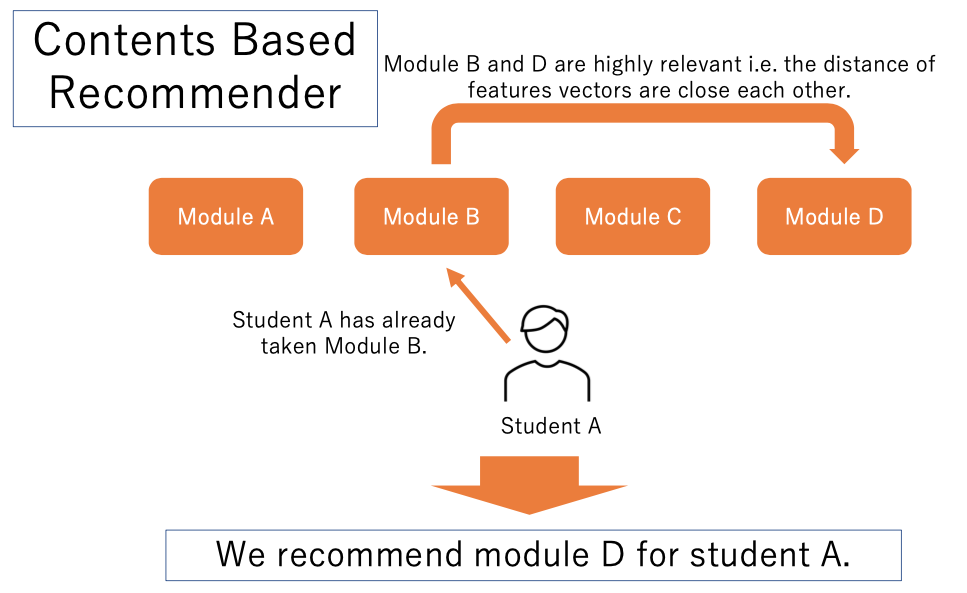

In [29]:
#Fitting model.
K = 6
model = NearestNeighbors(algorithm = "brute", n_neighbors = K)
fitted = model.fit(transformed_courses)

In [30]:
#We can output 5 most relevant modules by inputting 1 module, utilizing courses['code'] as the label.
def nearestClass(model, module, printing=True):

    courses_taken = courses[courses['code'].isin(module)]
    courses_taken_index = courses_taken.index.values

    distance, indice = model.kneighbors(transformed_courses[courses_taken_index].reshape(1,-1), n_neighbors=6)

    #Just for printing purpose.
    if printing == False:
      return distance, indice
    else:
      for i in range(0, len(distance.flatten())):
          if  i == 0:
              print('Contents of {0} is as follows: \n'.format(courses['code'][indice.flatten()[i]]))
              print(courses['info'][indice.flatten()[i]])
              print('\n Relevant modules of {0} are shown as follows: \n'.format(courses['code'][indice.flatten()[i]]))
          else:
              print('{0}: {1} with distance: {2}'.format(i, courses['code'][indice.flatten()[i]], distance.flatten()[i]))
              print(courses['info'][indice.flatten()[i]])
              print('')

In [31]:
nearestClass(fitted, ['CS2100'], printing=True)

Contents of CS2100 is as follows: 

The objective of this module is to familiarise students with the fundamentals of computing devices. Through this module students will understand the basics of data representation, and how the various parts of a computer work, separately and with each other. This allows students to understand the issues in computing devices, and how these issues affect the implementation of solutions. Topics covered include data representation systems, combinational and sequential circuit design techniques, assembly language, processor execution cycles, pipelining, memory hierarchy and input/output systems.

 Relevant modules of CS2100 are shown as follows: 

1: CS4232 with distance: 8.717797887081348
The objective of this module is to provide students with a theoretical understanding of what can be computed, and an introduction to the theory of complexity. It aims to introduce

2: CS4248 with distance: 8.717797887081348
This module deals with computer processing of h

It is time to see our model in action. Let's see what modules our model reommends based on the modules taken by a student.

Write a function that takes in a *pre-trained* model of your choice as input and the list of modules. It returns the top-K recommendations of the model. Print the top 6 recommendations for the first student. 

                                                                                                      (3 marks)

In my case, I took average of student_vector. The difference between the sum and the average of vectors are shown in following webite clearly. Both the sum and the average can work as the "feature vector that shows one students' total taste regarding 5 module taking". However, to compare students vector with each modules' vector by same scale, I choose taking average of student vector.

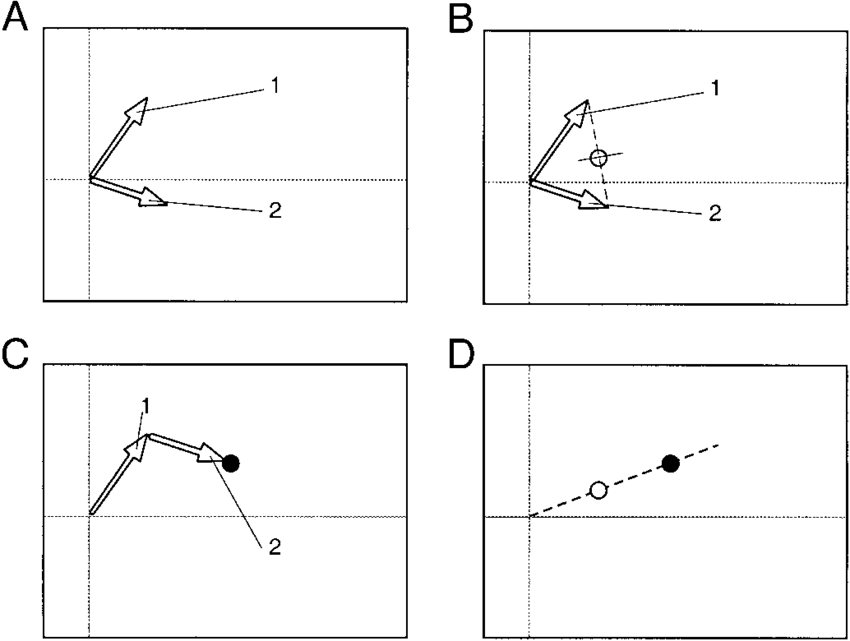

Reference: https://www.researchgate.net/figure/Computation-of-vector-sum-and-vector-average-A-single-vectors-the-same-ones-as-in-the_fig5_7122829

In [32]:
def recommend(model, modulesTaken, k = 5):
    '''
        Write your code here
    '''
    
    #obtain studens' aggregated vectors from 5 modules taken in Xtest.
    student_vector = getFeatureVector(modulesTaken, featureTransformer)

    #for error checking purpose in development.
    #display(student_vector)

    #check the number of modulesTaken
    nummodules_taken = len(modulesTaken)
    #dividing student_vector by the nummodules_taken, to obtain gravity center of the 
    #modules' vectors taken by student.
    mean_student_vector = student_vector / nummodules_taken

    #taking neighbors of mean_student_vector. For case where k-neighbors contain
    #same modules that the student has already taken,
    #we obtain n_neighbors as k + nummodules_taken + 1.
    distance, indice = model.kneighbors(mean_student_vector.reshape(1,-1), 
                                        n_neighbors= k + nummodules_taken + 1)

    #get index values of courses taken by the student
    #i.e. return index values of Xtest[0]
    courses_taken = courses[courses['code'].isin(modulesTaken)]
    courses_taken_index = courses_taken.index.values.flatten()

    #exclude modules that the student has already taken in modulesTaken i.e. Xtest[0] etc.
    distance_nottakenyet = distance.flatten()[np.invert(np.isin(indice.flatten(),courses_taken_index))]
    indice_nottakenyet = indice.flatten()[np.invert(np.isin(indice.flatten(),courses_taken_index))]

    #convert module index (0-158) into module codes such as "CS2100" etc
    modules_recommend = courses['code'][courses.index.isin(indice_nottakenyet)].values

    #return top k closest distances and those modules
    return distance_nottakenyet[:k], modules_recommend[:k]

In [33]:
K = 6

In [34]:
model = NearestNeighbors(algorithm = "brute", n_neighbors = K)
fitted = model.fit(transformed_courses)

In [35]:
_, recommend_modules = recommend(model, Xtest[0], k = K)
recommend_modules

array(['CS4232', 'CS4239', 'CS4248', 'CS5226', 'CS5230', 'CS5248'],
      dtype=object)

# Question 3: Recommender evaluation

Is this the model any good?. To do so, we use **precision** and **recall** as our metrics. `Ytest` consists of true labels for every students. Using those labels as the ground truth, compute the precision and recall for every student. Write a code that prints values of average precision and recall for a specific value of `K` over the `students` dataset. Print the value of average precision and average recall for `K= 10`.

                                                                                                     (2 marks)

Checking the data property of Ytest

In [36]:
Ytest

0      [CS3282, CS6204, CS5223, CS3281, CS4344, CS542...
1      [CS5331, CS6209, CS4257, CS4236, CS5322, CS523...
2      [CS5344, CS4232, CS4243, CS5242, CS3236, CS623...
3      [CS3281, CS5232, CS4880, CS4218, CS3202, CS527...
4      [CS6280, CS6203, CS2220, CS5228, CS4220, CS422...
                             ...                        
995    [CS4215, CS2104, CS3212, CS6215, CS5271, CS620...
996    [CS3236, CS5230, CS6234, CS3225, CS2220, CS523...
997    [CS4212, CS6213, BT5110, CS5214, CS4221, CS422...
998    [CS3882, CS3271, CS6280, CS2103, CS3216, CS328...
999    [CS6231, CS3282, CS4236, CS3281, CS5232, CS523...
Name: modules, Length: 1000, dtype: object

In [37]:
K = 10

In [38]:
model = NearestNeighbors(algorithm = "brute", n_neighbors = K)
fitted = model.fit(transformed_courses)

In [39]:
#Making K=10 recommendation to each 1000 students.
#It can take 2-3 minutes.
Ypred = Xtest.apply(lambda x: recommend(model, x, K)[1])

In [40]:
Ypred

0      [CS4231, CS4232, CS4239, CS4248, CS5226, CS522...
1      [CS3225, CS4231, CS4232, CS4238, CS4248, CS522...
2      [CS3225, CS4231, CS4232, CS4239, CS5226, CS523...
3      [CS3225, CS3281, CS4231, CS4232, CS4248, CS522...
4      [CS4224, CS4231, CS4232, CS4248, CS5226, CS523...
                             ...                        
995    [CS4231, CS4232, CS4239, CS4248, CS5226, CS523...
996    [CS3225, CS4232, CS4239, CS4248, CS5226, CS523...
997    [CS4231, CS4232, CS4239, CS4248, CS5226, CS523...
998    [CS3225, CS3281, CS3283, CS4231, CS4232, CS423...
999    [CS3282, CS4231, CS4232, CS4238, CS4248, CS522...
Name: modules, Length: 1000, dtype: object

In [41]:
Ypred[0]

array(['CS4231', 'CS4232', 'CS4239', 'CS4248', 'CS5226', 'CS5229',
       'CS5230', 'CS5248', 'CS5330', 'CS5344'], dtype=object)

Now, we can calculate precision and recall at K in recommendation system shown as followings.

Iu = Subset of test data i.e. number of Ytest in this assignment

Yu(K) = Recommended K items to each users (students), which corresponds to the number of Ypred in this assignment

Yu(K)　∩　Iu = Correctly recommended data i.e. Data both in Yu(K) and lu 

precision(K) = | Yu(K)　∩　Iu | / |Yu(K)|

recall(K) = | Yu(K)　∩　Iu | / | Iu |

Reference: "Ilya Katsov, Introduction to Algorithmic Marketing: Artificial Intelligence for Marketing Operations, 2017, p284" shown as follows.

https://www.amazon.com/dp/0692142606/ref=cm_sw_em_r_mt_dp_H3TGT5A9MEEPRZ7CQZ20


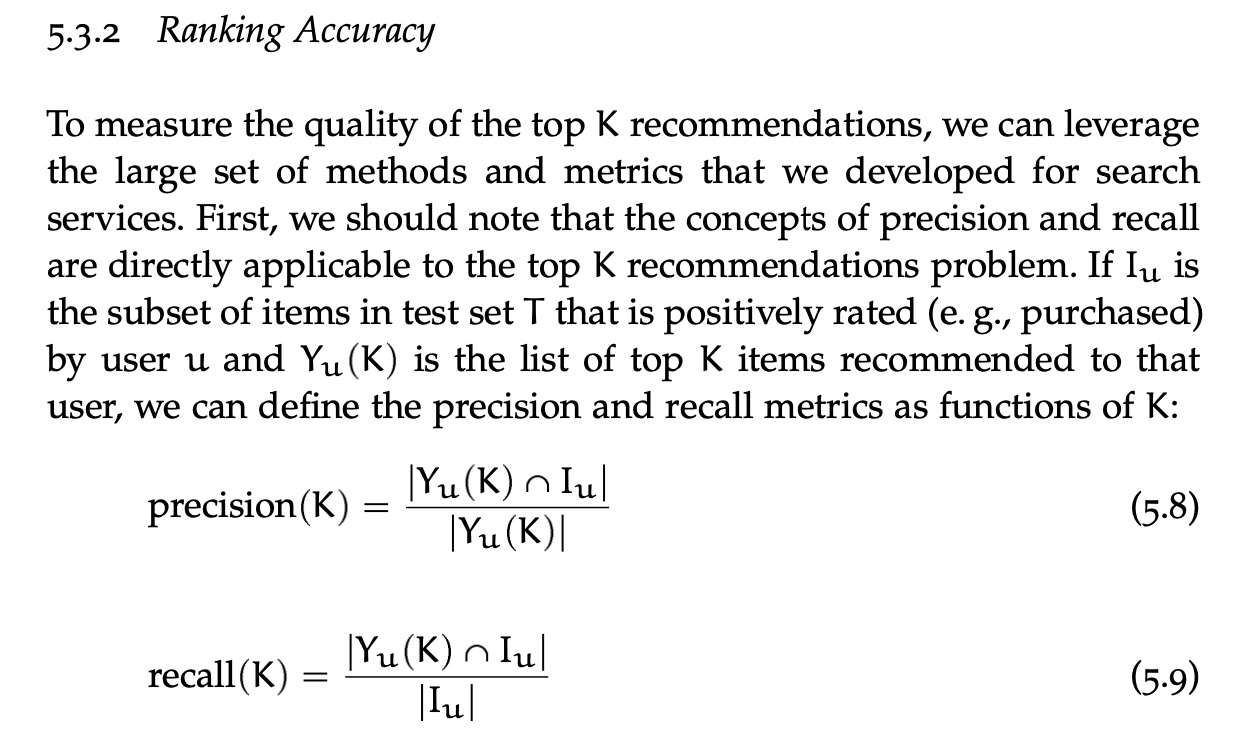

In [42]:
#First, creating function to calculate | Yu(K)　∩　Iu |
#i.e. the number of correct recommendation to one student.
def countCorrectRecommendation(YpredData, YtestData):
  ypred_df = pd.Series(YpredData)
  ytest_df = pd.Series(YtestData)

  return ypred_df.isin(ytest_df).sum()

In [43]:
countCorrectRecommendation(Ypred[2],Ytest[2])

3

In [44]:
#Then, creating function to calculate precision, recall, and F-score,
#by utilizing countCorrectRecommendation().
def calculateRecallPrec(Ypred, Ytest, printing=True):

  #count total number of our recommendations i.e. Ypred, which corresponds to 
  num_Ypred = Ypred.apply(lambda x: len(x)).sum()
  #count total number of subset data for module in Ytest
  num_Ytest = Ytest.apply(lambda x: len(x)).sum()
  #count total number of our correct recommendations in 1000 students,
  #using countCorrectRecommendation
  sum_correct = 0
  for i in range(len(Ypred)):
    temp_correct_pred = countCorrectRecommendation(Ypred[i], Ytest[i])
    sum_correct = sum_correct + temp_correct_pred  

  #precision(K) is stated as |Yu(K)　∩　Iu | / |Yu(K)|
  precision = sum_correct / num_Ypred
  #recall(K) is stated as | Yu(K)　∩　Iu | / | Iu |
  recall = sum_correct / num_Ytest
  #F-score is the halmonic mean of precision and recall
  F1_score = 2 * precision * recall /(precision + recall)

  if printing == True:
    print("Precision is :" + str(precision))
    print("Recall is :" + str(recall))
    print("F1-score is :" + str(F1_score))
  
  else:
    return precision, recall, F1_score

In [45]:
calculateRecallPrec(Ypred, Ytest,printing=True)

Precision is :0.1237
Recall is :0.13727666185772944
F1-score is :0.1301351848929567


We observe that both precision and recall is not really great. The reason might be igh feature dimension, which may even be noisy. Append the exisiting `featureTransformer` with a PCA to reduce the dimension. 

Print the value of average precision and recall for `K= 10` after the introduction of PCA.

                                                                                                     (2 marks)

In [46]:
class PCATransformer:        

    def __init__(self, n_components = 10):
      #n_components is the number of features after the dimensionality reduction by PCA.
      self.featureTransformer_plain = FeatureUnion([
          ('workload_processing', Pipeline([('wrkld', WorkloadTransformer())])),
          ('info_processing', Pipeline([('info', InfoTransformer())])),
          ('code_processing', Pipeline([('code', CodeTransformer())])),
      ])
      self.n_components = n_components

    def fit(self, X, y = None, **fit_params):
        return self
    
    def transform(self, X, y = None, **fit_params):

        self.featureTransformer_plain.fit(X)
        transformed_courses = self.featureTransformer_plain.transform(X)

        self.pca = PCA(random_state=rng, n_components = self.n_components)
        self.modulesvec_feature_reduced = self.pca.fit_transform(transformed_courses)

        return self.modulesvec_feature_reduced

In [47]:
featureTransformer = FeatureUnion([
    ('pca_processing', Pipeline([('pca', PCATransformer(n_components = 10))])),
])

featureTransformer.fit(courses)
transformed_courses_pca = featureTransformer.transform(courses)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Checking how the function works. We can reduce the number of features to n_components = 10, for 159 of each modules.

In [49]:
transformed_courses_pca.shape

(159, 10)

In [50]:
K = 10

In [51]:
model = NearestNeighbors(algorithm = "brute", n_neighbors = K)
fitted = model.fit(transformed_courses_pca)

In [52]:
#Making K=10 recommendation to each 1000 students.
#It can take 3-5 mins
Ypred_pca = Xtest.apply(lambda x: recommend(model, x, K)[1])

After we reduce demension of feature vector to 10 from more than 2000 by PCA, we could improve all precision, recall, and F1-score.

In [53]:
calculateRecallPrec(Ypred_pca, Ytest,printing=True)

Precision is :0.1391
Recall is :0.15436688491843303
F1-score is :0.14633633159749618


Extend the code to perform a grid search for the value of `K` that provides the best `F1_score`. Try for values of K from 1 to 10.

                                                                                                     (2 marks)

In [54]:
#initial value of best f1 and k
best_f1, best_k = 0.0, None
#Run grid-search of k from 1 to 10. It can take 20-30mins.
for k in range(1,11):
  model = NearestNeighbors(algorithm = "brute", n_neighbors = k)
  fitted = model.fit(transformed_courses_pca)
  Ypred_pca = Xtest.apply(lambda x: recommend(model, x, k)[1])

  _, _, f1_score = calculateRecallPrec(Ypred_pca, Ytest,printing=False)

  print('F1-score of K={0} is {1}'.format(k, f1_score))

  if f1_score > best_f1:
    best_f1, best_k = f1_score, k

print('The Best result is obtained when k={0} with F1-score of {1}'.format(best_k, best_f1))


F1-score of K=1 is 0.032364399160922985
F1-score of K=2 is 0.06339115430024521
F1-score of K=3 is 0.09108317375738906
F1-score of K=4 is 0.10606409960802397
F1-score of K=5 is 0.11590892869887943
F1-score of K=6 is 0.1247085470654853
F1-score of K=7 is 0.13440759477858974
F1-score of K=8 is 0.14014461230968195
F1-score of K=9 is 0.14591083226916882
F1-score of K=10 is 0.14696754510546525
The Best result is obtained when k=10 with F1-score of 0.14696754510546525


# Bonus question

Can you provide some **concrete** (something that you can implement) suggestions to improve the performance of the system?

                                                                                                    (2 marks)

### Idea 1: We can optimize the number of features in PCA, in addition to K in KNN.

(Note: It can take about 30-50 mins to complete all grid-searches)

In [55]:
K = 10
pca_range = [1,2,3,4,5,10,20,30,40,50,75,100]
#initial value of best f1 and n_components in PCA
best_f1, best_ncomp = 0.0, None
#Run grid-search of k from 1 to 10. It can take 20-30mins.
for ncomp in pca_range:
  featureTransformer = FeatureUnion([
      ('pca_processing', Pipeline([('pca', PCATransformer(n_components = ncomp))])),
  ])
  featureTransformer.fit(courses)
  transformed_courses_pca = featureTransformer.transform(courses)

  model = NearestNeighbors(algorithm = "brute", n_neighbors = K)
  fitted = model.fit(transformed_courses_pca)
  Ypred_pca = Xtest.apply(lambda x: recommend(model, x, K)[1])

  _, _, f1_score = calculateRecallPrec(Ypred_pca, Ytest,printing=False)

  print('F1-score of n_components={0} is {1}'.format(ncomp, f1_score))

  if f1_score > best_f1:
    best_f1, best_ncomp = f1_score, ncomp

print('The Best result is obtained when n_components={0} with F1-score of {1}'.format(best_ncomp, best_f1))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=1 is 0.0843722055651991
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=2 is 0.10762190310872653
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=3 is 0.12824154436904947
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=4 is 0.15790857924359583
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=5 is 0.13718373573194464
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=10 is 0.1492

As a result of grid search of n_components in PCA, we could obtain the better F1-score than we didn't optimize n_components!

###Idea 2: Implementing User based (Students based in this assignment) recommender.

In question 1-3, we implemented "contents based" recommender. It assumes that student A will take similar contents of modules in Ytest as the student A has already taken modules in Xtest.

On the other hands, we can also assume that, in Ytest, the student A will take similar modules that the student B, who owns similar direction of learning, has already taken in Xtest. In short, similar students with similar appetite of learning direction can take same modules, such that let's recommend student A the modules that the similar student B has already taken!...This is "user based" recommendation. Picture is shown as follows.

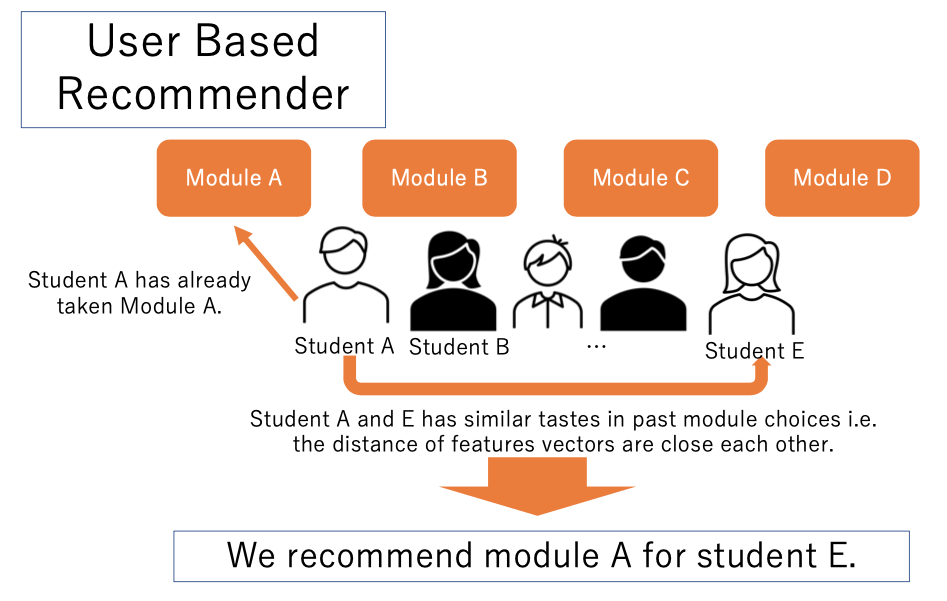

I intuitively thought that the assumption of "user based recommendation", i.e. similar direction of students can take similar modules, can be more effective in terms of module selection in university. Therefore, I tried to implement this "user based" or ("student based" in this context) recommendation as following.

In [56]:
#Here is just same as contents based recommender. We can create feature vectors 
#for each modules.
featureTransformer = FeatureUnion([
    ('pca_processing', Pipeline([('pca', PCATransformer(n_components = 10))])),
])

featureTransformer.fit(courses)
transformed_courses_pca = featureTransformer.transform(courses)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
#Creating feature vectors for all 1000 students
#It can take 3-5 mins
allstudent_vectors_pca = Xtest.apply(lambda x: getFeatureVector(x, featureTransformer))

In [58]:
#data preprocessing to create pandas dataframe for feature vectors of all 1000 students.
allstudent_vectors_pca_series = allstudent_vectors_pca.apply(lambda x: x.flatten())
allstudent_vectors_pca_df = pd.DataFrame()
for i in range(len(allstudent_vectors_pca_series)):
  df_temp = pd.DataFrame(allstudent_vectors_pca_series[i]).T
  allstudent_vectors_pca_df = pd.concat([allstudent_vectors_pca_df, df_temp], axis = 0)

allstudent_vectors_pca_df = allstudent_vectors_pca_df.reset_index()
allstudent_vectors_pca_df = allstudent_vectors_pca_df.drop(['index'], axis = 1)

In [59]:
#This is the output of the feature vectors for 1000 students.
allstudent_vectors_pca_df.tail()

,0,1,2,3,4,5,6,7,8,9
995,-4.202424,-3.681316,-1.821386,2.004639,1.201983,7.100460,-1.070689,-4.233923,-1.491789,2.283065
996,-3.681716,3.115182,-5.100950,0.294528,1.918860,5.503114,2.215515,-0.953057,0.752131,-3.485984
997,-3.036837,0.466358,0.759983,4.468935,1.140030,3.110607,0.521115,-1.666385,2.527629,1.543609
998,-1.185048,-10.691061,2.462521,-0.977218,0.947635,3.982181,4.016616,-0.022191,-5.343684,-2.590116
999,-1.785269,-8.421639,-0.107070,-3.462630,-1.896887,-1.745669,-0.812542,-2.045138,-1.112292,-3.716821


Here is the point for user based recommendation system. We create and fit K-NN model to 1000 of students' vectors to find "top K of similar tastes of students with student A".

In [60]:
K = 10

In [61]:
#apply K-NN to 1000 students of feature vectores after PCA,
#to implement User base recommendation.
model = NearestNeighbors(algorithm = "brute", n_neighbors = K)
fitted = model.fit(allstudent_vectors_pca_df)

In [62]:
def userBasedRecommendation(model, studentIndex, k = 5):
  #Get k*10 closest students of one student.
  #About n_neighbors, there are many duplicates of modules taken
  #(Actually some students have taken completely same modules in Xtest), 
  #such that getting 10 times more neighbors for allowance.
  distance, indice = model.kneighbors(allstudent_vectors_pca_df.iloc[studentIndex,:].to_numpy().reshape(1,-1), n_neighbors= k * 10)

  #Data preprocessing: obtain pandas Series for indice i.e. k*10 closest students.
  indice_series = pd.Series(indice.flatten())
  #Data preprocessing: obtain pandas DataFrame for indice i.e. k*10 closest students.
  indice_df = pd.DataFrame(indice.flatten(), columns=['index'])
  #obtain all student data of 5 taken modules 
  Xtest_df = pd.DataFrame(Xtest).reset_index()

  #merge indice_df (k*10 closest student index numbers) and Xtest_df (all student data), 
  #by keeping order of k*10 closest students.
  close_students = indice_df.merge(indice_df.merge(Xtest_df, how='left', on = 'index', sort=False))

  #Get whole modules list that the closest k*10 students have taken in Xtest.
  modules_list_store = []
  close_students.iloc[1:,1].apply(lambda x: modules_list_store.append(x))
  #integrate into one merged list of all modules taken by the closest k*10 students
  modules_list_final = list(itertools.chain(*modules_list_store))
  #Eliminate duplication of modules taken by the closest k*10 students
  unique_modules_list = list(dict.fromkeys(modules_list_final))

  #extract the modules that the student has already taken.
  studenttaken_modules = close_students['modules'][0]
  #Eliminate modules that the very this student has already taken.
  final_recommendation = np.array(unique_modules_list)[np.invert(np.isin(unique_modules_list, studenttaken_modules))]

  #return first k modules as recommendation
  return final_recommendation[:k]

In [63]:
Xtest[0]

['CS2105', 'CS4222', 'CS6270', 'CS6205', 'CS4226']

In [64]:
userBasedRecommendation(model, 0, 10)

array(['CS5321', 'CS3103', 'CS6204', 'CS5229', 'CS3282', 'CS6213',
       'CS4271', 'CS4231', 'CS5239', 'CS3284'], dtype='<U6')

In [65]:
#Create recommendations for 1000 students
Ypred_userbased = allstudent_vectors_pca_df.index.map(lambda x: userBasedRecommendation(model, x, k=K))
#convert into pandas series to read into calculateRecallPrec()
Ypred_userbased_final = pd.Series(Ypred_userbased)

In [66]:
calculateRecallPrec(Ypred_userbased_final, Ytest,printing=True)

Precision is :0.2237
Recall is :0.2482521362778826
F1-score is :0.23533743622113515


Try to implement PCA n_components optimization by grid search.　(Note: It can take about 30-40 mins)

In [67]:
pca_range = [1,2,3,4,5,10,20,30,40,50,75,100]
#initial value of best f1 and n_components in PCA
best_f1, best_ncomp = 0.0, None
#Run grid-search of k from 1 to 10. It can take 20-30mins.
for ncomp in pca_range:
  featureTransformer = FeatureUnion([
      ('pca_processing', Pipeline([('pca', PCATransformer(n_components = ncomp))])),
  ])
  featureTransformer.fit(courses)
  transformed_courses_pca = featureTransformer.transform(courses)

  #Creating feature vectors for all 1000 students
  allstudent_vectors_pca = Xtest.apply(lambda x: getFeatureVector(x, featureTransformer))

  #data preprocessing to create pandas dataframe for feature vectors of all 1000 students.
  allstudent_vectors_pca_series = allstudent_vectors_pca.apply(lambda x: x.flatten())
  allstudent_vectors_pca_df = pd.DataFrame()
  for i in range(len(allstudent_vectors_pca_series)):
    df_temp = pd.DataFrame(allstudent_vectors_pca_series[i]).T
    allstudent_vectors_pca_df = pd.concat([allstudent_vectors_pca_df, df_temp], axis = 0)

  allstudent_vectors_pca_df = allstudent_vectors_pca_df.reset_index()
  allstudent_vectors_pca_df = allstudent_vectors_pca_df.drop(['index'], axis = 1)

  #apply K-NN to 1000 students of feature vectores after PCA,
  #to implement User base recommendation.
  model = NearestNeighbors(algorithm = "brute", n_neighbors = K)
  fitted = model.fit(allstudent_vectors_pca_df)
  #apply userBasedRecommendation to all students to obtain Ypred
  Ypred_userbased = allstudent_vectors_pca_df.index.map(lambda x: userBasedRecommendation(model, x, k=K))
  #convert into pandas series to calculateRecallPrec()
  Ypred_userbased_final = pd.Series(Ypred_userbased)

  _, _, f1_score = calculateRecallPrec(Ypred_userbased_final, Ytest,printing=False)

  print('F1-score of n_components={0} is {1}'.format(ncomp, f1_score))

  if f1_score > best_f1:
    best_f1, best_ncomp = f1_score, ncomp

print('The Best result is obtained when n_components={0} with F1-score of {1}'.format(best_ncomp, best_f1))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=1 is 0.08310977854926095
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=2 is 0.14591552259218346
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=3 is 0.16348429856398927
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=4 is 0.1803166587764978
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=5 is 0.19641260322970908
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
F1-score of n_components=10 is 0.2344

Yes, actually, with PCA n_components grid search, user based recommendation could achieve further better F1-score.

Reference: "Ilya Katsov, Introduction to Algorithmic Marketing: Artificial Intelligence for Marketing Operations, 2017" shown as follows.

https://www.amazon.com/dp/0692142606/ref=cm_sw_em_r_mt_dp_H3TGT5A9MEEPRZ7CQZ20